In [10]:
using Plots
using SpecialFunctions
using NLsolve
using Random
using LaTeXStrings

## How to sample points from nonrectangular domains?

* Recall the previous circle problem. We needed a square that enclosed the circle. Which of the two situations will be more efficient?

<img src="https://ignite.byu.edu/che541/lectures/figs/l38f01.png" width="400">



* Clearly the case on the right is better. We will have fewer wasted darts in the smaller blue square area on the right. 


* Similarly, the case on the right in the figure below will be more accurate.
<img src="https://ignite.byu.edu/che541/lectures/figs/l38f02.png" width="500">

* **But how do we sample uniformly under the half circle the right figure?**
    * For a rectangle, we just used a uniform random number generator to get random x and y points.
    * There are routines for generating random points that fit some given distribution, such as normally distributed random points. 

### Approach

* Let the curve we want to generate points on be $g(x)$. 
* Let $G(x)=\int_a^xg(x)dx,$ where $a$ is the lower bound of integration.
* We sample uniformly on $G$ and invert to find the corresponding $x=G^{-1}$.
* The resulting $x$ locations will be distributed consistent with $g(x)$.
* To get the $y$ location of a point corresponding to $x$, we sample a random number uniformly on $[0,\,g(x)]$.


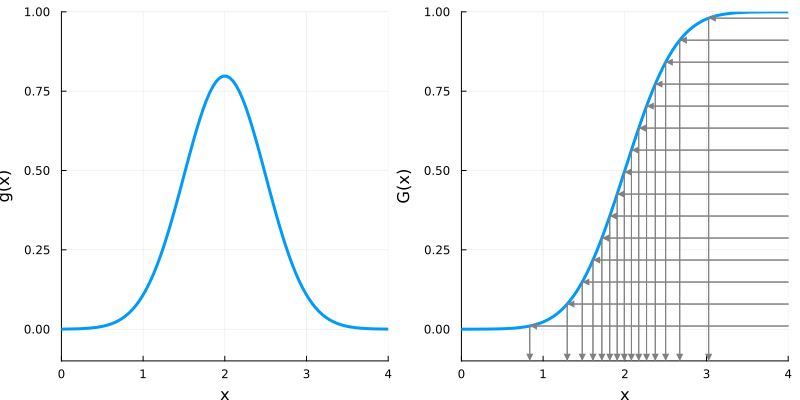

In [138]:
function make_plot()
    μ = 2.0
    σ = 0.5
    x = LinRange(0,4,100)
    g = @. 1/sqrt(2*pi*σ^2)*exp(-1/2/σ^2*(x-μ)^2)
    G = @. 0.5*(1+erf(1/σ/sqrt(2)*(x-μ))) 
        
    #fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    plot(x,g, lw=3)
    plot!(xlabel="x", ylabel="g(x)")
    p1=plot!(xlim=[0,4], ylim=[-0.1,1], legend=nothing)
    
    plot(x,G, lw=3)
    plot!(xlabel="x", ylabel="G(x)")
    p2=plot!(xlim=[0,4], ylim=[-0.1,1], legend=nothing)
    
    function Ginv(xFind, Gwant)
        return [0.5*(1+erf(1/σ/sqrt(2)*(xFind[1]-μ))) - Gwant]
    end
    
    GR.setarrowsize(0.6)
    for yy in LinRange(0.01,0.98,15)
        xx = nlsolve((F,x)->F[:]=Ginv(x,yy), [μ]).zero[1]
        p2=plot!([4,xx],[yy,yy],arrow=:closed, arrowheadsize=0.1,color=:gray,lw=1,label="")
        p2=plot!([xx,xx],[yy,-0.1],arrow=:closed, arrowheadsize=0.1,color=:gray,lw=1,label="")
    end
        
    p=plot(p1, p2, layout=(1,2), size=(800,400))
    display(p)
end

make_plot()


#### Example: let $g(x)$ be a normal distribution

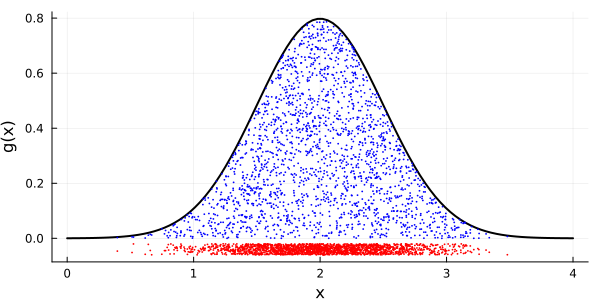

In [2]:
n    = 2000                        # number of points

#---------- Define g(x)

μ    = 2.
σ    = 0.5
maxG = 1.0
g(x) = 1/sqrt(2*pi*σ^2)*exp(-1/2/σ^2*(x-μ)^2)

#---------- get g(x) distributed random x points

rG = rand(n)*maxG      # uniform samples on G
rx = zeros(n)          # corresponding x locations found next

function Ginv(xFind, Ggiven)          # inverse function: G --> x
    return [0.5*(1+erf(1/σ/sqrt(2)*(xFind[1]-μ))) - Ggiven]
end

rx[1] = nlsolve((F,x)->F[:]=Ginv(x,rG[1]), [μ]).zero[1]

for (i, rGi) in enumerate(rG)
    rx[i] = nlsolve((F,x)->F[:]=Ginv(x,rGi), [μ]).zero[1]
end
    
#---------- get y points below g(x)

ry = [rand()*g(rx[i]) for i in 1:n]

#---------- plot results

x = LinRange(0,2*μ,100)

plot(x, g.(x), lw=2, color="black")
scatter!(rx, ry, ms=1, color="blue", markerstrokewidth=0)
scatter!(rx, rand(length(rx))*0.04 .- 0.06, ms=1, color="red", markerstrokewidth=0)
plot!(xlabel="x", ylabel="g(x)", legend=nothing, size=(600,300))

### Sampling nonuniformly distributed random numbers
* Most random number generators provide uniformly distributed random numbers on the domain $[0,\,1]$.
* In the previous example, we saw how to sample random points that are normally distributed. 
    * Specifically, the selection of $x$ points will be normally distributed.
    * This means that there are more $x$ points near $\mu$ where the peak is, than on the tails.
    * In the above example, we also found corresponding random $y$ points.
    * **However, in this section, we are only interested in the nonuniformly distributed $x$ points.**
    * For example, plotting a histogram of the ```rx``` points above gives:

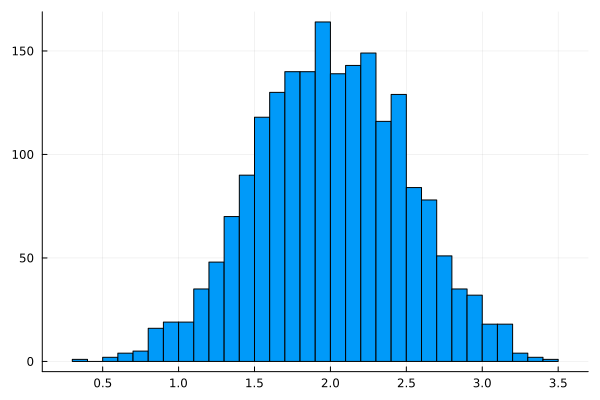

In [3]:
histogram(rx, bins=40, legend=nothing)

* The previous method is difficult if the integration of $g(x)$ is complex or expensive and/or if the subsequent inversion of $G(x)$ is complex or expensive. 
* Another method for sampling uniformly distributed points from a nonrectangular region is similar to the MC integration problem.
* However, we are not doing integration here, only showing another method for sampling from a nonuniform distribution. 
* This method does not require integration of $g(x)$ or inversion of $G(x)$. 
* We draw a bounding curve $F(x)$ that is easy to integrate and invert. This could be a rectangle.
    * $F(x)$ is everywhere greater than $g(x)$.
* Then we draw an $r_x$ point from from the bounding curve, as previously described (using G(x)).
* Now we accept the sample point with probability $g(r_x)/F(r_x)$.
    * This is done by sampling a random number between 0 and 1. If the random number is less than $g(r_x)/F(r_x)$, then we accept the point, otherwise we reject it.
* This approach is called the **rejection method**.



#### Example

* Sample random normally distributed variables using the rejection method.

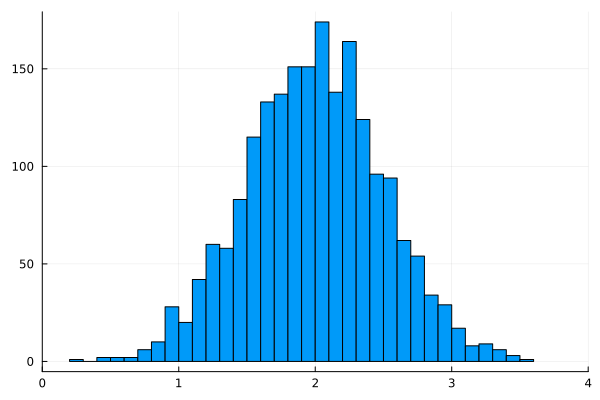

In [6]:
function make_plot2()
    n    = 8000                 # random numbers to try (not all kept)
    μ    = 2.
    σ    = 0.5
    g(x) = 1/sqrt(2*pi*σ^2)*exp(-1/2/σ^2*(x-μ)^2)
    F(x) = 1                    # bounding function, here a simple uniform profile
    
    #-----------------
    
    nkeep = 0                   # total number kept: incremented below
    rx_all = Float64[]          # storage for all points: expanded below
    
    for i in 1:n
        rx = rand()*2*μ
        Paccept = g(rx)/F(rx)
        r  = rand()
        if r<Paccept
            append!(rx_all, rx)
            nkeep += 1
        end
    end
            
    #-----------------
    
    histogram(rx_all, bins=40, legend=nothing)
    p=plot!(xlim=[0,4])
    display(p)
end

make_plot2()
    

## Example-Poisson Process

* Poisson Processes are extremely important in probability theory.
* Used to model random processes in time and space
    * Raindrop spacing, radioactive decay, eddies in turbulence, etc.
    


### Raindrops

* Suppose it's raining lightly and you listen to the time spacing of droplets. 
* There will be some average rate.
* But sometimes drops will be very close together, and sometimes very far apart.


#### Question: what is the distribution of the spacing between events (droplets) and can we model this?

* **Find the PDF of intervals between events; that is $p(\Delta t_e)$**.
* Assume events occur randomly in time with a mean event rate $\lambda$ (=) $s^{-1}$. That is, $\lambda$ drops per second, on average.
* Assume events are statistically independent of each other.
* The probability of getting an event in some interval $dt$ is $\lambda dt$, or $dt/T$, where $T=1/\lambda$ is the mean time between events.
* Consider the interval $(t_0,\,t_0+\Delta t_e)$, with some sub-intervals:

```
|  1     2     3     4  |
|-----|-----|-----|-----|
| dt    dt    dt    dt  |
t0                    t0+Dt_e
```



* The probability of **not** getting an event in sub-interval 1 is $1-\lambda dt$. 
* The probability of not getting an event in sub-interval 1 **and** sub-interval 2 **and** $\ldots$ sub-interval 4 is 

$$(1-\lambda dt)^4,$$

* or, for $n$ sub-intervals

$$(1-\lambda dt)^n \rightarrow (1-\lambda dt)^{\Delta t_e/dt}$$




* Now, let $dt\rightarrow 0$.
* $P(t_{\text{next event}}>\Delta t_e) = \lim_{dt\rightarrow 0}(1-\lambda dt)^{\Delta t_e/dt}$.
* Now, at $dt=0$ we have $1^{\infty}$. Work on this:

\begin{align}
\ln P &= \ln \left[\lim_{dt\rightarrow 0}(1-\lambda dt)^{\Delta t_e/dt}\right], \\
      &= \lim_{dt\rightarrow 0}\ln\left[(1-\lambda dt)^{\Delta t_e/dt}\right],\\
      &= \lim_{dt\rightarrow 0}\frac{\Delta t_e}{dt}\ln\left[1-\lambda dt\right].\\
\end{align}




* Now, at $dt=0$ we have $0/0$, so use L'Hopital's Rule.

$$\ln P = \lim_{dt\rightarrow 0}\frac{-\lambda \Delta t_e}{(1-\lambda dt)} = -\lambda \Delta t_e.$$

Hence, 
$$P(t_{\text{next event}}>\Delta t_e)  = e^{-\lambda \Delta t_e}.$$
Or,
$$P(t_{\text{next event}}<\Delta t_e)  = 1- e^{-\lambda \Delta t_e}.$$


* This is a cumulative distribution function. 
* Differentiate it to get the probability density function:

<font color="blue">
$$p(\Delta t_e) = \lambda e^{-\lambda \Delta t_e}.$$
</font>

* This is an exponential distribution.
* So, to generate exponentially-distributed events, randomly sample $\Delta t_e$ values from this distribution.
    * As above, draw uniform samples of $P(\Delta t_e)$ (the cumulative distribution function) on $[0,\,1]$. Invert this function to get $\Delta t_e$.
    * The inversion, is just solving the expression for $P(\Delta t_e)$ for $\Delta t_e$, where $P$ values are taken as random numbers between 0 and 1:
    
    $$\Delta t_e = -\frac{\ln(1-P)}{\lambda}.$$

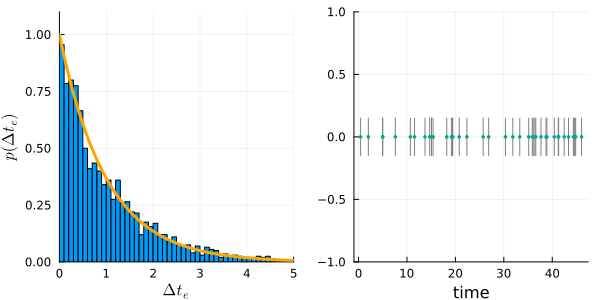

In [29]:
function make_plot3()
    λ = 1
    n = 2000
    rP = rand(n)
    Δt_e = -log.(1 .-rP)/λ
    
    x = LinRange(0,8,1000)
    y = λ*exp.(-λ*x)
    
    times = cumsum(Δt_e[1:40])
    
    histogram(Δt_e, bins=80, normalize=:pdf)
    plot!(x,y, lw=3, legend=nothing, color="orange")
    plot!(xlabel=L"\Delta t_e")
    plot!(ylabel=L"p(\Delta t_e)")
    p1=plot!(xlim=[0,5], ylim=[0,1.1])
    
    plot()
    for t in times
        plot!([t,t],[-0.15,0.15], lw=1, color="gray")
    end
    scatter!(times, zeros(length(times)), ms=2, markerstrokewidth=0)
    p2=plot!(xlabel="time", ylim=[-1,1], legend=nothing)
    
    plot!(p1,p2, layout=(1,2), size=(600,300))
end

make_plot3()